In [1]:
#typical ML imports (from NN example ipynb)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
#from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-12-22 19:30:55.232425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [82]:
# Python file with supporting sub-functions
import data_utils

# Open and Check CESM Data

In [ ]:
def import_model_data(ens, member, date_start, date_end):
    
    base_url = '/home/julias/MLEE-final-project/raw_data/{}_2D_mon_{}{}_1x1_198201-201701.nc'
    XCO2_url = '/home/julias/MLEE-final-project/raw_data/{}_1D_mon_{}{}_native_198201-201701.nc'
    mask_path = '/home/julias/MLEE-final-project/raw_data/create_mask.nc'

    variables = {'Chl','FG-CO2','iceFrac','MLD','pATM','pCO2','SSS','SST','U10','XCO2'}

    full_potential_variables_list = []
    inputs = {}
    inputs['socat_mask'] = xr.open_dataset(mask_path).socat_mask.sel(time=slice(date_start,date_end))
#time = inputs['socat_mask']

    for variable in variables:

        if variable=='Chl':    
            Chl_path = base_url.format(variable,ens,member)
            inputs['Chl'] = xr.open_dataset(Chl_path).Chl.sel(time=slice(date_start,date_end)).assign_coords(time=inputs['socat_mask'].time)
            full_potential_variables_list.append(Chl_path)
        if variable=='MLD':    
            MLD_path = base_url.format(variable,ens,member)
            inputs['MLD'] = xr.open_dataset(MLD_path).MLD.sel(time=slice(date_start,date_end)).assign_coords(time=inputs['socat_mask'].time)
            full_potential_variables_list.append(MLD_path)
        if variable=='pATM':    
            pATM_path = base_url.format(variable,ens,member)
            inputs['pATM'] = xr.open_dataset(pATM_path).pATM.sel(time=slice(date_start,date_end)).assign_coords(time=inputs['socat_mask'].time)
            full_potential_variables_list.append(pATM_path)
        if variable=='pCO2':    
            pCO2_path = base_url.format(variable,ens,member)
            inputs['pCO2'] = xr.open_dataset(pCO2_path).pCO2.sel(time=slice(date_start,date_end)).assign_coords(time=inputs['socat_mask'].time)
            full_potential_variables_list.append(pCO2_path)
        if variable=='SSS':    
            SSS_path = base_url.format(variable,ens,member)
            inputs['SSS'] = xr.open_dataset(SSS_path).SSS.sel(time=slice(date_start,date_end)).assign_coords(time=inputs['socat_mask'].time)    
            full_potential_variables_list.append(SSS_path)
        if variable=='SST':    
            SST_path = base_url.format(variable,ens,member)
            inputs['SST'] = xr.open_dataset(SST_path).SST.sel(time=slice(date_start,date_end)).assign_coords(time=inputs['socat_mask'].time)
            full_potential_variables_list.append(SST_path)
        
    # Note that XCO2 requires a slightly different URL
        if variable=='XCO2':
            XCO2_path = XCO2_url.format(variable,ens,member)
            inputs['XCO2'] = xr.open_dataset(XCO2_path).XCO2.sel(time=slice(date_start,date_end)).assign_coords(time=inputs['socat_mask'].time)
            full_potential_variables_list.append(XCO2_path)
        
        if variable=='FG-CO2' or variable=='iceFrac' or variable=='U10':
            full_potential_variables_list.append(base_url.format(variable,ens,member))
    
    for i in inputs:        
        if i != 'XCO2' and i != 'socat_mask':
            inputs[i] = inputs[i].assign_coords(xlon=(((inputs[i].xlon+180)%360)-180)) # wraps from 0 to 360 to -180 to 180
            inputs[i] = inputs[i].sortby(inputs[i].xlon)    
        
    DS = xr.merge([inputs['SSS'], inputs['SST'], inputs['MLD'], inputs['Chl'], inputs['pCO2'], inputs['socat_mask']])
    
    return DS, inputs['XCO2'], full_potential_variables_list

In [3]:
# Define ens (ensemble) and member (member number) so that all subsequent lines would be valid in a loop for a testbed approach
ens = 'CESM'
member = '009'

# Define date range
# In this case, CESM from 1982-2017 and SOCAT from 1970-2022, so keep CESM full range and will trim SOCAT
date_start = '1982-02'
date_end = '2017-01'
# LATER: check input[each] date and lat/lon and make sure all coming in reasonably

In [105]:
CESM_data, XCO2_data, possible_variables_list = data_utils.import_model_data(ens, member, date_start, date_end)

In [106]:
CESM_data

<xarray.Dataset>
Dimensions:     (xlon: 360, ylat: 180, time: 420)
Coordinates:
  * xlon        (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time        (time) datetime64[ns] 1982-02-15 1982-03-15 ... 2017-01-15
Data variables:
    SSS         (time, ylat, xlon) float32 ...
    SST         (time, ylat, xlon) float32 ...
    MLD         (time, ylat, xlon) float32 ...
    Chl         (time, ylat, xlon) float32 ...
    pCO2        (time, ylat, xlon) float64 ...
    socat_mask  (time, ylat, xlon) float64 ...
Attributes:
    long_name:     Sea Surface Salinity
    units:         gram/kilogram
    grid_loc:      3111
    cell_methods:  time: mean z_t: mean

In [107]:
XCO2_data

<xarray.DataArray 'XCO2' (time: 420)>
array([340.84854, 340.96225, 341.07544, ..., 406.5084 , 406.7395 , 406.97128],
      dtype=float32)
Coordinates:
    TLONG    float64 ...
    TLAT     float64 ...
  * time     (time) datetime64[ns] 1982-02-15 1982-03-15 ... 2017-01-15
Attributes:
    long_name:     Atmospheric CO2
    units:         ppmv
    grid_loc:      2110
    cell_methods:  time: mean xlon: mean ylat: mean

In [10]:
possible_variables_list

['/home/julias/MLEE-final-project/raw_data/XCO2_1D_mon_CESM009_native_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/SST_2D_mon_CESM009_1x1_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/U10_2D_mon_CESM009_1x1_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/SSS_2D_mon_CESM009_1x1_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/FG-CO2_2D_mon_CESM009_1x1_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/iceFrac_2D_mon_CESM009_1x1_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/Chl_2D_mon_CESM009_1x1_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/pCO2_2D_mon_CESM009_1x1_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/MLD_2D_mon_CESM009_1x1_198201-201701.nc',
 '/home/julias/MLEE-final-project/raw_data/pATM_2D_mon_CESM009_1x1_198201-201701.nc']

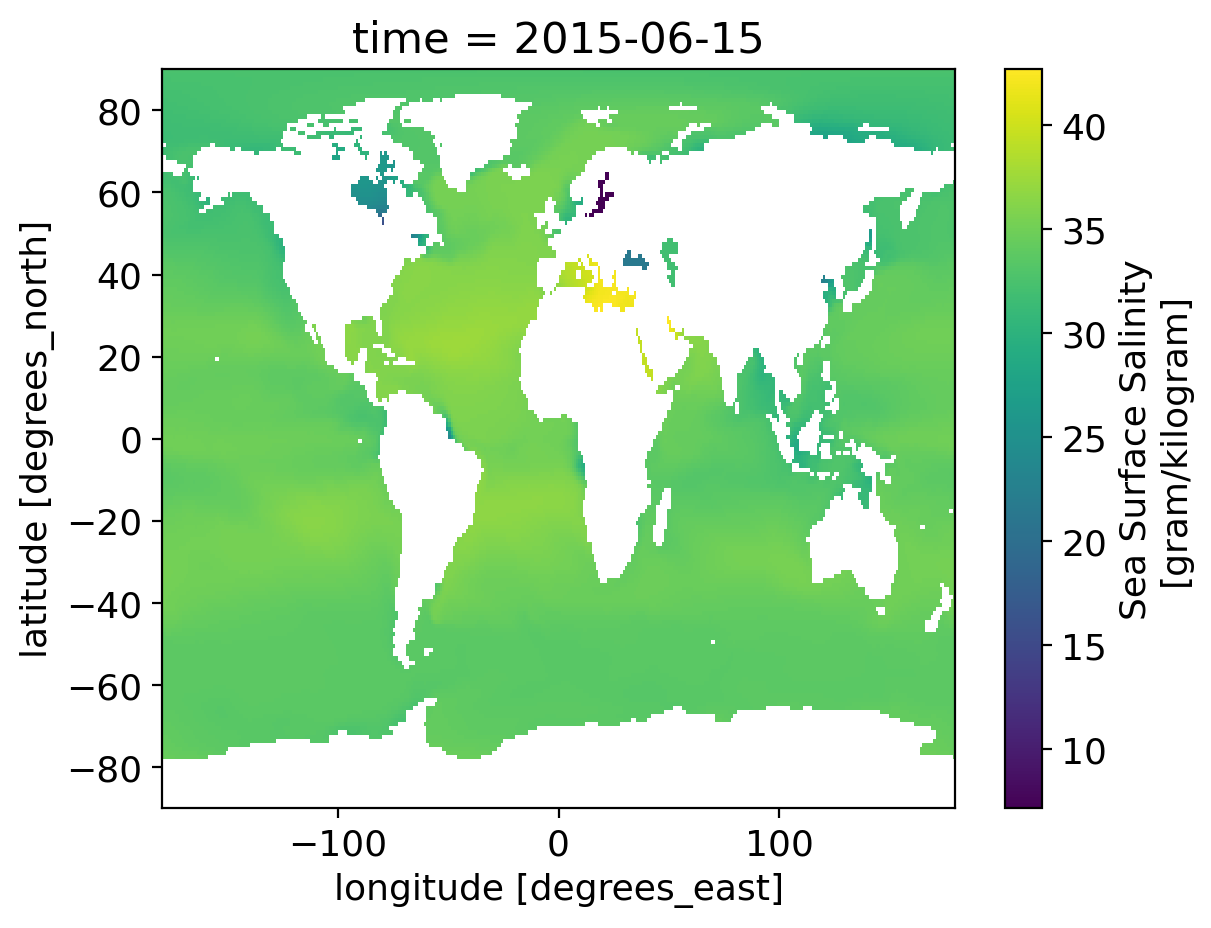

In [11]:
CESM_data.SSS[400,:,:].plot()

In [12]:
CESM_data.ylat

<xarray.DataArray 'ylat' (ylat: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5])
Coordinates:
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:      latitude
    bounds:         ylat_bnds
    standard_name:  latitude
    units:          degrees_north
    axis:           Y
    point_spacing:  even

In [13]:
CESM_data.xlon

<xarray.DataArray 'xlon' (xlon: 360)>
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5])
Coordinates:
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [102]:
CESM_data.indexes['xlon'].to_numpy()

array([-179.5, -178.5, -177.5, -176.5, -175.5, -174.5, -173.5, -172.5,
       -171.5, -170.5, -169.5, -168.5, -167.5, -166.5, -165.5, -164.5,
       -163.5, -162.5, -161.5, -160.5, -159.5, -158.5, -157.5, -156.5,
       -155.5, -154.5, -153.5, -152.5, -151.5, -150.5, -149.5, -148.5,
       -147.5, -146.5, -145.5, -144.5, -143.5, -142.5, -141.5, -140.5,
       -139.5, -138.5, -137.5, -136.5, -135.5, -134.5, -133.5, -132.5,
       -131.5, -130.5, -129.5, -128.5, -127.5, -126.5, -125.5, -124.5,
       -123.5, -122.5, -121.5, -120.5, -119.5, -118.5, -117.5, -116.5,
       -115.5, -114.5, -113.5, -112.5, -111.5, -110.5, -109.5, -108.5,
       -107.5, -106.5, -105.5, -104.5, -103.5, -102.5, -101.5, -100.5,
        -99.5,  -98.5,  -97.5,  -96.5,  -95.5,  -94.5,  -93.5,  -92.5,
        -91.5,  -90.5,  -89.5,  -88.5,  -87.5,  -86.5,  -85.5,  -84.5,
        -83.5,  -82.5,  -81.5,  -80.5,  -79.5,  -78.5,  -77.5,  -76.5,
        -75.5,  -74.5,  -73.5,  -72.5,  -71.5,  -70.5,  -69.5,  -68.5,
      

In [103]:
CESM_data.indexes['xlon'].to_numpy()
    
   # days_idx = df.index.get_level_values('time').dayofyear
lon_rad = np.radians(CESM_data.indexes['xlon'].to_numpy())
lat_rad = np.radians(CESM_data.indexes['ylat'].to_numpy())
df['A'], df['B'], df['C'] = [np.sin(lat_rad), np.sin(lon_rad)*np.cos(lat_rad), -np.cos(lon_rad)*np.cos(lat_rad)]
    

ValueError: operands could not be broadcast together with shapes (360,) (180,) 

In [97]:
CESM_data.indexes.get_level_values(xlon)

AttributeError: 'Indexes' object has no attribute 'get_level_values'

In [108]:
dates = CESM_data.time.values
N_batch = 12
CESM_dataframe = CESM_data.to_dataframe()

df = data_utils.create_features(CESM_data, N_time=len(dates), N_batch = N_batch) 
#need to get XCO2 to not be a coordinate, just data var
#and move to def, because don't want to be able to call more than once

NameError: name 'XCO2_data' is not defined

In [117]:
df['XCO2'] = np.repeat(XCO2_data.values, 360*180)

In [125]:
df_int = df.drop_indexes('XCO2')
df_new = df_int.reset_coords('XCO2')
df_new
# NEED TO: set time, ylat, xlon as XCO2 dimension and remove it as its own dimension

<xarray.Dataset>
Dimensions:     (xlon: 360, ylat: 180, time: 420, XCO2: 27216000)
Coordinates:
  * xlon        (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time        (time) datetime64[ns] 1982-02-15 1982-03-15 ... 2017-01-15
Dimensions without coordinates: XCO2
Data variables:
    SSS         (time, ylat, xlon) float32 nan nan nan nan ... 32.13 32.13 32.14
    SST         (time, ylat, xlon) float32 nan nan nan ... -1.801 -1.801 -1.801
    MLD         (time, ylat, xlon) float32 nan nan nan nan ... 57.42 57.44 57.48
    Chl         (time, ylat, xlon) float32 nan nan nan ... 0.0144 0.0144 0.0144
    pCO2        (time, ylat, xlon) float64 nan nan nan nan ... 379.6 379.5 379.5
    socat_mask  (time, ylat, xlon) float64 nan nan nan nan ... nan nan nan nan
    T0          (time) float64 0.7025 0.2926 -0.2345 ... 0.7147 0.9668 0.9668
    T1          (time) float64 0.7117 0.9562 0.9721 ... -0.6995 -0.2554 0.2554
    XCO2        (XCO2) float32 340.8 340.8 340.8 340.8 ... 407.0 407.0 407.0
Attributes:
    long_name:     Sea Surface Salinity
    units:         gram/kilogram
    grid_loc:      3111
    cell_methods:  time: mean z_t: mean

In [140]:
df_new['XCO2'].assign_coords(time=df.time,ylat=df.ylat,xlon=df.xlon)

ValueError: cannot add coordinates with new dimensions to a DataArray

In [123]:
# cesm_historical = cesm_historical.assign_coords(longitude=longitude).assign_coords(latitude=latitude)
df['XCO2'].assign_coords(time=df.time)

ValueError: cannot add coordinates with new dimensions to a DataArray

In [61]:
lon1 = CESM_data.xlon
lon2 = np.where(lon1 < 0, lon1+360, lon1)
lon2
lon_rad = np.radians(lon1)
lon_rad
lat_rad = np.radians(CESM_data.ylat.values)
lat_rad
df['A'], df['B'], df['C'] = [np.sin(lat_rad), np.sin(lon_rad)*np.cos(lat_rad), -np.cos(lon_rad)*np.cos(lat_rad)]

ValueError: operands could not be broadcast together with shapes (360,) (180,) 

# Access SOCAT Data from Artemis

In [ ]:
#look at Val's pre SOCAT py file

path_SST = '/local/data/artemis/observations/NOAA_OI_SSTv2/processed/sst_1x1_mon_NOAAOIv2_198112-201908.nc'

path_SSS = '/local/data/artemis/observations/EN422_salinity/processed/sss_1x1_mon_EN422_197901-202012.nc'

path_xCO2 = #'https://gml.noaa.gov/ccgg/mbl/'
#make sure includes lat lon variations (via pressure field) and water vapor correction
# using pressure:
path_pres = '/local/data/artemis/observations/ERA5_MSLP/ERA5_MSLP_1x1_1979-2021.nc' #make sure in atmospheres
#expect 300 to 450 depending on year

path_chlA = '/local/data/artemis/observations/GlobColour/processed/globcolour-L3m-GSM_chl_1x1_monthly_198201-202112.nc'

path_MLD = '/local/data/artemis/observations/MLD_deBoyerMontegut/val_processed/mld_deboyer_1x1_clim_198201-201712.nc'
#LOOK AT Val's code, should be able to just add additional years, see if jan 2017 same as jan 2000
path_pCO2 = '/local/data/artemis/observations/SOCAT/processed/SOCATv2022_pCO2_gridded_monthly.nc'
#IF need to add CESM, /local/data/artemis/observations/CESM_hindcast/processed 

#ds1 = xr.open_dataset(‘/data/artemis/workspace/vbennington/GlobColour/originals/L3m_GLOB_CHL1_199801-202012.nc’)
#ds2 = xr.open_dataset(‘/data/artemis/workspace/afay/GlobColour/originals/L3m_GLOB_CHL1_202001-202112.nc’)

In [ ]:
df = ldeo_res_flux
lon = df.lon
print(lon.shape)
lon2 = np.where(lon < 0, lon+360, lon)
# # print(lon2)
df.coords['lon'] = (lon2)
df = df.sortby(df.lon)
# # print(df)
df[300,:,:].plot()
# # print(df.lon)
ldeo_res_flux360 = df
print(ldeo_res_flux360.dims)
print(ldeo_res_flux360.shape)
del df

In [ ]:
ds_pCO2 = xr.open_dataset(path_pCO2)
ds_SST = xr.open_dataset(path_SST)
ds_chlA = xr.open_dataset(path_chlA)

In [ ]:
print(ds_chlA) #NOTE WILL NEED TO STANDARDIZE LONGITUDE, and will need to standardize time
# check Val's scripts for time and lon conversions
# define a function for switching longitudes, see Amanda's example

In [ ]:
print(ds_pCO2)

In [ ]:
ds_pCO2.socat_mask.plot()

In [ ]:
dickson = pd.read_csv('/data/artemis/workspace/vbennington/Dickson_atmos/Dickson_monthly_pco2.csv')

In [ ]:
dickson.head() #only varies with time, not lat and lon

In [ ]:
# take time series of xCO2 and multiply by time and space-varying pressure